In [1]:
import sys
sys.path.append("../src")

In [101]:
from ds.models import SkinstressionCNN
import collections
from types import SimpleNamespace
import numpy as np
import torch
from torch.nn import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.nn.parallel import DataParallel

from matplotlib.colors import LinearSegmentedColormap, SymLogNorm
import matplotlib.pyplot as plt

from captum.attr import Occlusion
from captum.attr import visualization as viz

from torchvision import transforms
from PIL import Image

import os
from glob import glob
from pathlib import Path

In [3]:
class NestedNamespace(SimpleNamespace):
    """Sot that the stub config dictionary can be accessed by the model
    as if it was the hydra config file.
    """
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

In [6]:
cfg = {
    "params": {
        "model": {
            "n_nodes": 64,
            "num_output_features": 3
        }
}}
cfg = NestedNamespace(cfg)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model_path = "/scistor/guest/sjg203/projects/shg-strain-stress/model_zoo/20.pt"

In [7]:
model = SkinstressionCNN(cfg)
checkpoint = torch.load(model_path)
new_state_dict = collections.OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace("module.", '') # remove 'module.' prefix, because of bug in checkpoint saving.
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model = model.eval()
model = model.to(device)
# model = DataParallel(model)

In [143]:
normal_img_path = "/scistor/guest/sjg203/projects/shg-strain-stress/data/sorted/55/0.bmp"
attacked_img_path = "/scistor/guest/sjg203/projects/shg-strain-stress/notebooks/55_0_white-attack.bmp"
attacked_extra_img_path = "/scistor/guest/sjg203/projects/shg-strain-stress/notebooks/55_0_black-attack.bmp"

normal_img = Image.open(normal_img_path)
attacked_img = Image.open(attacked_img_path)
attacked_extra_img = Image.open(attacked_extra_img_path)

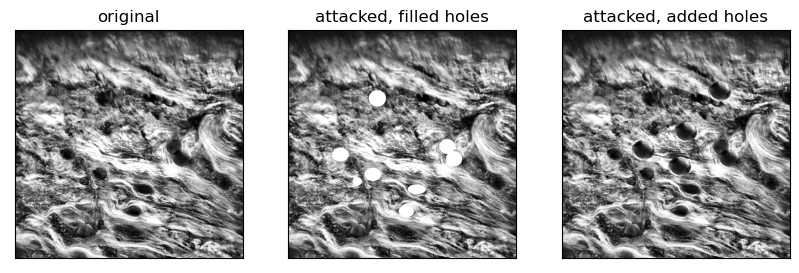

In [186]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title("original")
plt.imshow(normal_img, cmap='gray')
plt.yticks([])
plt.xticks([])

plt.subplot(1, 3, 2)
plt.title("attacked, filled holes")
plt.imshow(attacked_img, cmap='gray')
plt.yticks([])
plt.xticks([])

plt.subplot(1, 3, 3)
plt.title("attacked, added holes")
plt.imshow(attacked_extra_img, cmap='gray')
plt.yticks([])
plt.xticks([])

plt.savefig("outputs/attack/attack-viz.pdf", bbox_inches="tight")
# plt.show()

In [145]:
# model expects 258x258
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((1000, 1000)),
        transforms.CenterCrop((700, 700)),
        transforms.Resize((258, 258)),
    ]
)

In [146]:
transformed_normal_img = transform(normal_img).unsqueeze(0).to(device)
transformed_attacked_img = transform(attacked_img).unsqueeze(0).to(device)
transformed_attacked_extra_img = transform(attacked_extra_img).unsqueeze(0).to(device)
batch = torch.cat((transformed_normal_img, transformed_attacked_img, transformed_attacked_extra_img))

In [147]:
ablator = Occlusion(model)
attributions = ablator.attribute(batch, target=None, sliding_window_shapes=(1, 3, 3), show_progress=True)
attributions = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0))

Occlusion attribution: 100%|██████████| 65537/65537 [02:25<00:00, 451.62it/s]


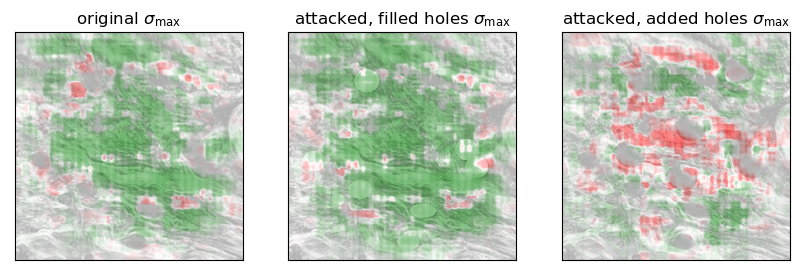

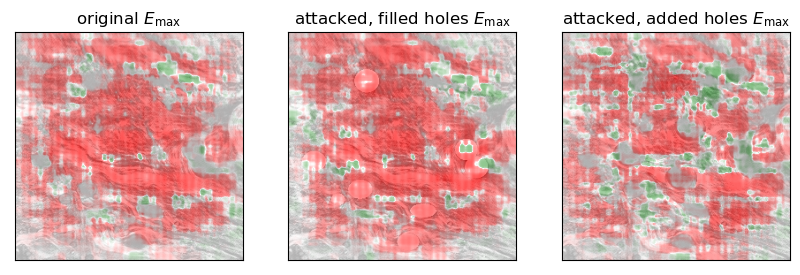

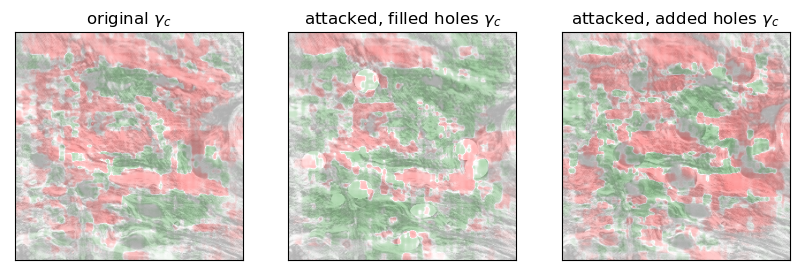

In [187]:
for attr_idx_1, attr_idx_2, attr_idx_3 in zip([0, 1, 2], [3, 4, 5], [6, 7, 8]):
    cmap = LinearSegmentedColormap.from_list(
                    "RdWhGn", ["red", "white", "green"]
                )
    if attr_idx_1 in [0, 1]:
        symloglin = 0.1
    else:
        symloglin = 0.001
    norm = SymLogNorm(symloglin, vmin=-1.8, vmax=1.8)

    if attr_idx_1 == 0:
        var = r"$\sigma_\mathrm{max}$"
    elif attr_idx_1 == 1:
        var = r"$E_\mathrm{max}$"
    else:
        var = r"$\gamma_c$"

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"original {var}")
    plt.imshow(transformed_normal_img.squeeze().unsqueeze(2).cpu().detach().numpy(), cmap='gray')
    plt.imshow(attributions[:, :, attr_idx_1], alpha=0.7, cmap=cmap, norm=norm)
    plt.yticks([])
    plt.xticks([])

    plt.subplot(1, 3, 2)
    plt.title(f"attacked, filled holes {var}")
    plt.imshow(transformed_attacked_img.squeeze().unsqueeze(2).cpu().detach().numpy(), cmap='gray')
    plt.imshow(attributions[:, :, attr_idx_2], alpha=0.7, cmap=cmap, norm=norm)
    plt.yticks([])
    plt.xticks([])

    plt.subplot(1, 3, 3)
    plt.title(f"attacked, added holes {var}")
    plt.imshow(transformed_attacked_extra_img.squeeze().unsqueeze(2).cpu().detach().numpy(), cmap='gray')
    plt.imshow(attributions[:, :, attr_idx_3], alpha=0.7, cmap=cmap, norm=norm)
    plt.yticks([])
    plt.xticks([])

    plt.savefig(f"outputs/attack/holes-occlusion-{attr_idx_1}.pdf", bbox_inches="tight")
    # plt.show()

In [163]:
original_output = model(transformed_normal_img)
attacked_output = model(transformed_attacked_img)
attacked_extra_output = model(transformed_attacked_extra_img)

print("original", original_output)
print("attacked removed holes", attacked_output)
print("attacked extra holes", attacked_extra_output)

original tensor([[ 7.2372, 17.4733,  1.2164]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
attacked removed holes tensor([[ 8.0195, 16.5244,  1.2261]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
attacked extra holes tensor([[ 3.7558, 20.5145,  1.2247]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


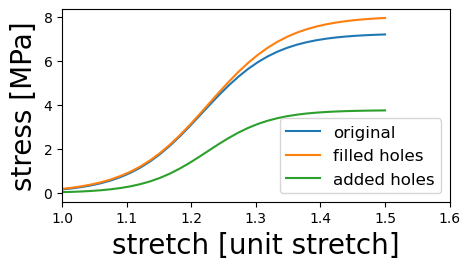

In [188]:
def logistic(x, a, k, xc):
    return a / (1 + np.exp(-k * (x - xc)))

plt.figure(figsize=(5, 2.5))
x = torch.linspace(0, 1.5, 100)
plt.plot(x, logistic(x, *original_output.squeeze().cpu().detach()), label="original")
plt.plot(x, logistic(x, *attacked_output.squeeze().cpu().detach()), label="filled holes")
plt.plot(x, logistic(x, *attacked_extra_output.squeeze().cpu().detach()), label="added holes")
plt.legend(fontsize=12, loc='lower right')
plt.xlabel("stretch [unit stretch]", fontsize=20)
plt.ylabel("stress [MPa]", fontsize=20)
plt.xlim([1, 1.6])

# plt.show()
plt.savefig("outputs/attack/holes.pdf", bbox_inches="tight")